In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from pprint import pprint
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier,AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, Lars, BayesianRidge, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from xgboost import XGBRFRegressor
import xgboost as xgb
from sklearn.linear_model import SGDRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import shap
import warnings
warnings.filterwarnings("ignore")



sns.set()

In [40]:
df = pd.read_excel('Realized Schedule 20210101-20220228.xlsx')
df_predict = pd.read_excel('Future Schedule 20220301-20220331.xlsx')
df['LoadFactor']=df['LoadFactor']*100
sns.boxplot(df,column=['SeatCapacity','LoadFactor'])
df=df.iloc[3500:]


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [39]:
df

,ScheduleTime,Airline,FlightNumber,Destination,AircraftType,FlightType,Sector,SeatCapacity,LoadFactor
3500,2021-05-23 08:40:00,DO,972,YYJ,32N,J,CA,180,8.333333
3501,2021-05-23 10:05:00,CN,512,EST,AT7,J,US,72,37.500000
3502,2021-05-23 12:00:00,BT,660,NPA,DH4,J,US,76,46.052632
3503,2021-05-23 12:35:00,DO,986,YXC,32N,J,CA,180,12.222222
3504,2021-05-23 11:15:00,JZ,822,YHM,AT7,J,CA,74,67.567568
...,...,...,...,...,...,...,...,...,...
39444,2022-02-28 18:45:00,VW,986,YYZ,319,J,CA,144,84.722222
39445,2022-02-28 19:25:00,LJ,667,YDQ,319,J,CA,156,87.179487
39446,2022-02-28 20:00:00,VW,3406,MYV,E90,J,US,98,85.714286
39447,2022-02-28 19:30:00,LJ,663,RUT,32N,J,US,186,68.279570


dividing timestamp into year, day and month.

In [3]:
df['year'] = df.ScheduleTime.apply(lambda x: x.year)
df['day'] = df.ScheduleTime.apply(lambda x: x.weekday())
df['month'] = df.ScheduleTime.apply(lambda x: x.month)

Binning the hours into 4 diffreent categories. 

In [4]:
bins = [0, 6, 12, 18, 24]
labels = ['night', 'morning', 'daytime', 'afternoon']
df['time'] = pd.cut(df.ScheduleTime.dt.hour, bins,labels=labels)

In [5]:
df['SeatCapacity']=pd.qcut(df['SeatCapacity'],q=5,labels=['small','noice','medium','largebitches','largemegaomega'])

Binning the Months into vinter, spring, summer and fall.

In [6]:
bins = ["Winter", "Spring", "Summer", "Fall"]
df['Season'] = df.month%12 //3
df['Season'] = df['Season'].apply(lambda x : bins[x])

Dummy on sector, flighttype, time and Season

In [7]:
df=pd.get_dummies(df,columns=['Sector','FlightType','time', 'Season','day','year','AircraftType','SeatCapacity'],drop_first=True)

Cleaning a bit

In [8]:
df = df.drop(['ScheduleTime', 'month'], axis=1)

Doing frequency encoding of destination and airline

In [9]:
fe_ = df.groupby("Destination").size()/len(df)
df['freq_destination'] = df["Destination"].map(fe_).round(4)

fe_ = df.groupby("Airline").size()/len(df)
df['freq_airline'] = df["Airline"].map(fe_).round(3)

fe_ = df.groupby("FlightNumber").size()/len(df)
df['freq_flightnumber'] = df["FlightNumber"].map(fe_).round(3)

In [10]:
# corr=df.corr()
# plt.figure(figsize=(25,25))
# sns.heatmap(corr, annot=True)
# plt.title("Correlations heatmap")
# plt.show()

In [11]:
#df = df[df['year_2022']==1]
X = df.loc[:, df.columns != 'LoadFactor']
y = df['LoadFactor']
N, P = X.shape
X['FlightType_O']=0

In [12]:
X = X.drop(['Airline','Destination','FlightNumber',], axis=1)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [14]:
def runModel(model):
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    print("& %.3f" %MSE(y_test,y_pred) + " & %.3f" %np.sqrt(MSE(y_test,y_pred))+ " & %.3f" %MAE(y_test,y_pred)+ " & %.3f" %r2_score(y_test,y_pred)+ " & %.3f" %accuracy(y_test,y_pred))

In [24]:
runModel(XGBRFRegressor())
model=XGBRFRegressor()
model.fit(X_train,y_train)

& 0.046 & 0.215 & 0.178 & 0.367 & 0.364


XGBRFRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bytree=1, enable_categorical=False, gamma=0, gpu_id=-1,
               importance_type=None, interaction_constraints='',
               max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
               monotone_constraints='()', n_estimators=100, n_jobs=12,
               num_parallel_tree=100, objective='reg:squarederror',
               predictor='auto', random_state=0, reg_alpha=0,
               scale_pos_weight=1, tree_method='exact', validate_parameters=1,
               verbosity=None)

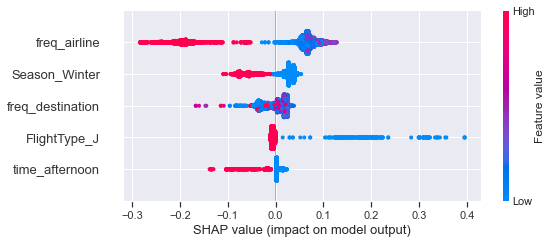

In [29]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test,max_display=5)

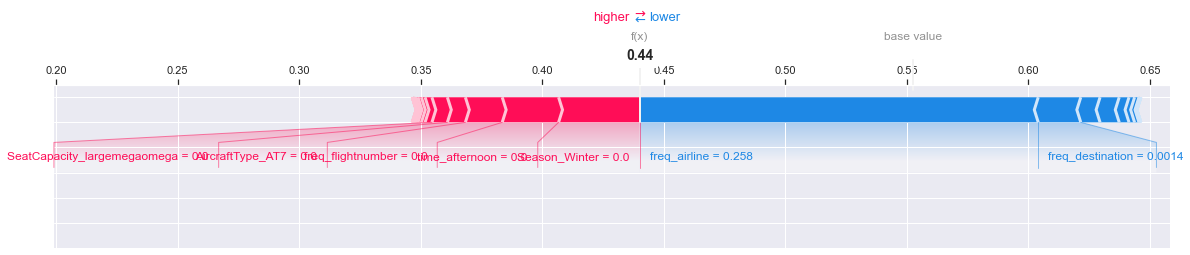

In [34]:
shap.force_plot(explainer.expected_value, shap_values[240,:], 
                X_test.iloc[240,:],
                matplotlib=True
               )

In [118]:
model =  RandomForestRegressor()
param_grid = {
    'max_depth': list(range(5,30)),
    'n_estimators': [x for x in range(10,200)],
    'min_samples_split': [2,3,4,5,6],
    'min_samples_leaf': [4,5,6,7,8]
}

boost_random = RandomizedSearchCV(estimator = model, param_distributions = param_grid, n_iter=20, verbose = 2, n_jobs=6, return_train_score=True)
    
boost_random.fit(X, y)
pprint(boost_random.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'max_depth': 21,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 169}


In [30]:
runModel(RandomForestRegressor(max_depth= 21,
 min_samples_leaf= 4,
 min_samples_split=2,
 n_estimators= 169)) 

& 0.031 & 0.176 & 0.137 & 0.580 & 0.556


RandomForestRegressor with adaboost is the best option and therefor crossvalidation will be used on that.

In [44]:
model =  RandomForestRegressor(warm_start=True)
param_grid = {
    'max_depth': [15,17,19,21,23],
    'n_estimators': [x for x in range(73,82)],
    'min_samples_split': [2,3,4],
    'min_samples_leaf': [1,2,3]
}

boost_grid = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2, n_jobs=6 ,return_train_score=True, scoring='r2')
    
boost_grid.fit(X, y)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits


GridSearchCV(estimator=RandomForestRegressor(warm_start=True), n_jobs=6,
             param_grid={'max_depth': [15, 17, 19, 21, 23],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [73, 74, 75, 76, 77, 78, 79, 80, 81]},
             return_train_score=True, scoring='r2', verbose=2)

In [43]:
df_predict = pd.read_excel('Future Schedule 20220301-20220331.xlsx')
df_predict['year'] = df_predict.ScheduleTime.apply(lambda x: x.year)
df_predict['day'] = df_predict.ScheduleTime.apply(lambda x: x.weekday())
df_predict['month'] = df_predict.ScheduleTime.apply(lambda x: x.month)
bins = [0, 6, 12, 18, 24]
labels = ['night', 'morning', 'daytime', 'afternoon']
df_predict['time'] = pd.cut(df_predict.ScheduleTime.dt.hour, bins,labels=labels)
bins = ["Winter", "Spring", "Summer", "Fall"]
df_predict['Season'] = df_predict.month%12 //3
df_predict['Season'] = df_predict['Season'].apply(lambda x : bins[x])
df_predict=pd.get_dummies(df_predict,columns=['Sector','FlightType','time', 'Season','day','year'],drop_first=True)
df_predict = df_predict.drop(['ScheduleTime', 'month'], axis=1)
fe_ = df_predict.groupby("Destination").size()/len(df_predict)
df_predict['freq_destination'] = df_predict["Destination"].map(fe_).round(4)

fe_ = df_predict.groupby("Airline").size()/len(df)
df_predict['freq_airline'] = df_predict["Airline"].map(fe_).round(3)

X = df_predict.loc[:, df_predict.columns != 'LoadFactor']
X = X.drop(['Airline', 'FlightNumber', 'Destination', 'AircraftType'], axis=1)
X['Sector_MX']=0
X['Sector_NL']=0
X['Season_Spring']=0
X[ 'Season_Summer']=0
X['Season_Winter']=0
X['year_2022'] = 0 

In [20]:
def accuracy(y_test, yhat):
    acc = []
    for i in range(len(y_test)):
        if y_test.values[i]!=0:
            acc.append(1-abs((y_test.values[i]-yhat[i])/y_test.values[i]))
    return np.mean(acc)

In [17]:
def MSE(y_true, y_predict):
    squared = (y_true-y_predict)**2
    return np.sum(squared) / len(y_true)

def MAE(y_true, y_predict):
    abs_val = abs(y_true-y_predict)
    return np.sum(abs_val) / len(y_true)

In [18]:
def plot_search_results_grid(grid):
    results = grid.cv_results_
    means_test = results['split1_test_score']
    stds_test = results['std_test_score']
    means_train = results['split1_train_score']
    stds_train = results['std_train_score']

    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    fig, ax = plt.subplots(1,len(params),sharex='none',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.09, 0.5, 'Best split SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        y_2 = np.array(means_train[best_index])
        ax[i].plot(x, y_1, linestyle='--', marker='o', label='test')
        ax[i].plot(x, y_2, linestyle='-', marker='*',label='train' )
        ax[i].set_xlabel(p.upper())
    plt.show()